In [ ]:
import numpy as np
import pandas as pd
import random
import keras

각 video와 music에서 emotion vector 추출


In [ ]:
mu_saved_npz_train  = np.load('music_train.npz')
mu_saved_npz_test  = np.load('music_test.npz')

In [ ]:
mu_X_train=mu_saved_npz_train['X']
mu_y_train = mu_saved_npz_train['Y']
mu_X_test=mu_saved_npz_test['X']
mu_y_test = mu_saved_npz_test['Y']

In [ ]:
mu_saved_npz_train.close()
mu_saved_npz_test.close()

In [ ]:
mu_X_train.shape

(1583, 512)

In [ ]:
vi_saved_npz_train  = np.load('merge_video_train.npz')
vi_saved_npz_test  = np.load('merge_video_test.npz')

In [ ]:
vi_X_train=vi_saved_npz_train['X']
vi_y_train = vi_saved_npz_train['Y']
vi_X_test=vi_saved_npz_test['X']
vi_y_test = vi_saved_npz_test['Y']


In [ ]:
vi_saved_npz_train.close()
vi_saved_npz_test.close()


In [ ]:
vi_X_train.shape

(1583, 912)

In [ ]:
vi_X_test.shape

(396, 912)

Positive, Negative pair 생성

In [ ]:
## input 생성
train_video_input = []
train_music_input = []
train_label = []
po_idx = 0
ne_idx = 0
while po_idx != 100000:
  vi_i = random.randrange(0,vi_X_train.shape[0])
  mu_i = random.randrange(0,mu_X_train.shape[0])
  
  label = 1
  for i in range(6):
    if vi_y_train[vi_i][i] != mu_y_train[mu_i][i]:
      label = 0
  if label == 0:
    ne_idx += 1
    if ne_idx <= 100000:
      train_video_input.append(vi_X_train[vi_i])
      train_music_input.append(mu_X_train[mu_i])
      train_label.append(label)
    else:
      pass
    
  else:
    po_idx += 1
    train_video_input.append(vi_X_train[vi_i])
    train_music_input.append(mu_X_train[mu_i])
    train_label.append(label)




In [ ]:
train_video_input = np.array(train_video_input)

In [ ]:
train_music_input = np.array(train_music_input)

In [ ]:
train_label = np.array(train_label)

In [ ]:
train_video_input.shape

(200000, 912)

In [ ]:
## input 생성
test_video_input = []
test_music_input = []
test_label = []
po_idx = 0
ne_idx = 0
while po_idx != 20000:
  vi_i = random.randrange(0,vi_X_test.shape[0])
  mu_i = random.randrange(0,mu_X_test.shape[0])
  
  label = 1
  for i in range(6):
    if vi_y_test[vi_i][i] != mu_y_test[mu_i][i]:
      label = 0
  if label == 0:
    ne_idx += 1
    if ne_idx <= 20000:
      test_video_input.append(vi_X_test[vi_i])
      test_music_input.append(mu_X_test[mu_i])
      test_label.append(label)
    else:
      pass
    
  else:
    po_idx += 1
    test_video_input.append(vi_X_test[vi_i])
    test_music_input.append(mu_X_test[mu_i])
    test_label.append(label)

In [ ]:
test_video_input = np.array(test_video_input)

In [ ]:
test_music_input = np.array(test_music_input)

In [ ]:
test_label = np.array(test_label)

In [ ]:
test_video_input.shape

(40000, 912)

Embedding space에 mapping함

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense,Lambda,Dropout
from keras import backend as K

music_input = Input(shape = (512))
video_input = Input(shape = (912))

vi_feats = Dense(256)(video_input)
vi_feats = Dropout(0.5)(vi_feats)
mu_feats = Dense(256)(music_input)
mu_feats = Dropout(0.5)(mu_feats)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0]-tensors[1]))
L1_distance = L1_layer([vi_feats,mu_feats])

prediction = Dense(1,activation = 'sigmoid')(L1_distance)
metric_model = Model(inputs=[video_input, music_input], outputs=prediction)


In [ ]:
metric_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 912)]        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 256)          233728      input_14[0][0]                   
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 256)          131328      input_13[0][0]                   
____________________________________________________________________________________________

In [ ]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
def contrastive_loss(y_true, y_pred):
    y_true=tf.dtypes.cast(y_true, tf.float64)
    y_pred=tf.dtypes.cast(y_pred, tf.float64)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [ ]:
import keras
import tensorflow as tf
opt = keras.optimizers.Adam(learning_rate = 0.0001)
metric_model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])

history = metric_model.fit(
    [train_video_input, train_music_input], train_label,
    validation_data=([test_video_input, test_music_input], test_label),
    shuffle = True,
    batch_size=64,
    epochs=20)

Epoch 1/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.3087 - accuracy: 0.6159 - val_loss: 0.2437 - val_accuracy: 0.7033
Epoch 2/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.1773 - accuracy: 0.7703 - val_loss: 0.2232 - val_accuracy: 0.7340
Epoch 3/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.1277 - accuracy: 0.8306 - val_loss: 0.2144 - val_accuracy: 0.7441
Epoch 4/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.1006 - accuracy: 0.8651 - val_loss: 0.2096 - val_accuracy: 0.7486
Epoch 5/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.0848 - accuracy: 0.8856 - val_loss: 0.2086 - val_accuracy: 0.7499
Epoch 6/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.0744 - accuracy: 0.8993 - val_loss: 0.2043 - val_accuracy: 0.7537
Epoch 7/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.0660 - accuracy: 0.9111 - val_loss: 0.2041 - val_accuracy:

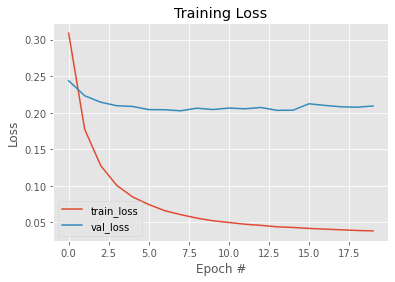

In [ ]:
# 그림 그리기
def plot_training_loss(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
plot_training_loss(history)

In [ ]:
metric_model.save('Deep_metric_model.h5')

In [ ]:
from keras.models import Model, load_model
metric_model = load_model('Deep_metric_model.h5',custom_objects = {'contrastive_loss':contrastive_loss})

In [ ]:
label = []
cal_auc_mu = []
cal_auc_vi = []
music = []
for j in range(vi_y_test.shape[0]):
  video_input = []
  music_input = []
  idx = []
  prediction = []
  for idx in range(396):
    video_input.append(vi_X_test[j])
    music_input.append(mu_X_test[idx])
  video_input = np.array(video_input)
  music_input = np.array(music_input)
  prediction=metric_model.predict([video_input,music_input])
  prediction=prediction.tolist()
  cal_auc_mu.append(mu_y_test[prediction.index(min(prediction))])
  cal_auc_vi.append(vi_y_test[j])
  la = 1
  music.append(prediction.index(min(prediction)))
  for i in range(6):
    if vi_y_test[j][i] != mu_y_test[prediction.index(min(prediction))][i]:
      la = 0
  label.append(la)
cal_auc_mu = np.array(cal_auc_mu)
cal_auc_vi = np.array(cal_auc_vi)

In [ ]:
print(sum(label)/len(label))

0.5883838383838383


결과 평가

In [ ]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(cal_auc_mu, cal_auc_vi)
print(roc_score)

0.7507248269311928


Text(33.0, 0.5, 'music emtion')

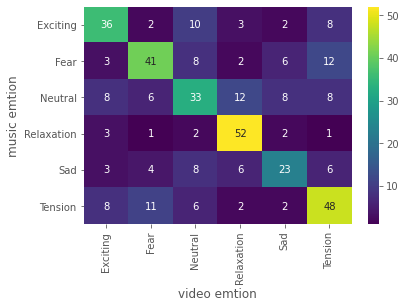

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
label = ['Exciting','Fear','Neutral','Relaxation','Sad','Tension']
cf = confusion_matrix(cal_auc_vi.argmax(axis =1),cal_auc_mu.argmax(axis=1))
sns.heatmap(cf, annot = True,xticklabels= label,yticklabels=label, cmap = 'viridis')
plt.xlabel("video emtion")
plt.ylabel("music emtion")

In [ ]:
a = 0
for j in range(cf.shape[1]):
  ans = 0
  for i in range(cf.shape[0]):
    ans += cf[i][j]
  print(cf[a][j]/ans)
  a+=1

0.9655172413793104
0.9827586206896551
0.8857142857142857
0.8414634146341463
0.9555555555555556
0.8795180722891566


In [ ]:
cf.shape[0]

6